In [9]:
import pandas as pd
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from datasets import Dataset, DatasetDict
from transformers import (
    AutoTokenizer, 
    AutoModel, 
    BertPreTrainedModel, 
    TrainingArguments, 
    Trainer
)
from transformers.modeling_outputs import SequenceClassifierOutput
from sklearn.metrics import accuracy_score
import accelerate
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from tqdm.auto import tqdm

tqdm.pandas()

# CUDAのデバッグ用
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

# --- 1. GPUの確認 ---
if torch.cuda.is_available():
    print(f"✅ GPU is available. Device: {torch.cuda.get_device_name(0)}")
    device = torch.device("cuda")
else:
    print("⚠️ GPU not found. Running on CPU.")
    device = torch.device("cpu")

✅ GPU is available. Device: NVIDIA GeForce RTX 3080 Ti


In [10]:
# --- 2. 設定 ---

TRAINING_FILE = "data/processed/training_dataset_abstract_cleaned_v3.csv"
MODEL_CHECKPOINT = "allenai/scibert_scivocab_uncased"

# --- 実験計画からのパラメータ ---
MAX_LENGTH = 512
LEARNING_RATE = 2e-5
# (RankNetではBCE損失を使うため、マージンは不要)

# --- ドライラン用の設定 ---
OUTPUT_MODEL_DIR = "models/sbert_ranknet_DRYRUN"
# (RankNetも3つの入力を処理するため、バッチサイズは小さく)
DRY_RUN_BATCH_SIZE = 4 
EPOCHS = 1
DRY_RUN_SUBSET_FRAC = 0.01 # データの1%だけを使用

print("Configuration set for RankNet Loss DRY RUN.")

Configuration set for RankNet Loss DRY RUN.


In [11]:
# --- 3. カスタムモデルクラスの定義 (CLS Pooling) ---

class SiameseRankNetModel(BertPreTrainedModel):
    """
    S-BERT (RankNet) モデル
    """
    def __init__(self, config):
        super(SiameseRankNetModel, self).__init__(config)
        # 1. エンコーダー（重みを共有）
        self.bert = AutoModel.from_config(config)
        
        # 2. スコア計算機（重みを共有）
        #    入力: [vec_a, vec_b, |a-b|, a*b] -> 出力: 1 (スコア)
        self.classifier_head = nn.Sequential(
            nn.Linear(config.hidden_size * 4, config.hidden_size),
            nn.ReLU(),
            nn.Linear(config.hidden_size, 1) # 最終的に1つのスコアを出力
        )
        self.init_weights()
    
    def _get_vector(self, input_ids, attention_mask):
        """SciBERTとCLSプーリングを実行するヘルパー関数"""
        output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        return output.pooler_output # CLSトークンのベクトル

    def _calculate_score(self, vec_a, vec_b):
        """2つのベクトルから1つのスコアを計算するヘルパー関数"""
        diff = torch.abs(vec_a - vec_b)
        prod = vec_a * vec_b
        features = torch.cat([vec_a, vec_b, diff, prod], dim=1)
        return self.classifier_head(features)

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        input_ids_positive=None,
        attention_mask_positive=None,
        input_ids_negative=None,
        attention_mask_negative=None,
        labels=None, # RankNetでは 'labels' は使わない
        **kwargs
    ):
        # 3つのベクトルを取得
        vec_anchor = self._get_vector(input_ids, attention_mask)
        vec_positive = self._get_vector(input_ids_positive, attention_mask_positive)
        vec_negative = self._get_vector(input_ids_negative, attention_mask_negative)

        # スコアを2回計算
        score_positive = self._calculate_score(vec_anchor, vec_positive)
        score_negative = self._calculate_score(vec_anchor, vec_negative)

        # 損失はTrainer側で計算
        return SequenceClassifierOutput(
            loss=None,
            # 2つのスコアをlogitsとして渡す
            logits=(score_positive, score_negative),
            hidden_states=None,
            attentions=None,
        )

print("Custom model class 'SiameseRankNetModel' (CLS Pooling) defined.")

Custom model class 'SiameseRankNetModel' (CLS Pooling) defined.


In [12]:
# --- 4. データセットの読み込みとTripletへの変換 ---
print(f"Loading dataset: {TRAINING_FILE}")
df_full = pd.read_csv(TRAINING_FILE)
df_full = df_full.dropna(subset=['abstract_a', 'abstract_b', 'label'])
df_full['label'] = df_full['label'].astype(int)
print(f"Full dataset size: {len(df_full)}")

# ▼▼▼ ドライラン用に1%のサブセットをサンプリング ▼▼▼
df = df_full.sample(frac=DRY_RUN_SUBSET_FRAC, random_state=42)
print(f"Using {len(df)} pairs for dry run ({DRY_RUN_SUBSET_FRAC*100}%)")

pos_df = df[df['label'] == 1]
neg_df = df[df['label'] == 0]

if pos_df.empty or neg_df.empty:
    raise ValueError("Dry run subset does not contain both positive and negative samples.")

# --- Tripletの作成 ---
triplets = []
negative_abstracts = neg_df['abstract_b'].tolist()
if not negative_abstracts:
    negative_abstracts = pos_df['abstract_b'].tolist() # フォールバック

for index, row in pos_df.iterrows():
    anchor = row['abstract_a']
    positive = row['abstract_b']
    negative = np.random.choice(negative_abstracts)
    
    triplets.append({
        'anchor': anchor,
        'positive': positive,
        'negative': negative
    })

df_triplets = pd.DataFrame(triplets)
# Trainerの評価ループを動作させるため、ダミーのlabels列を追加
df_triplets['labels'] = 0
print(f"Created {len(df_triplets)} triplets for the dry run.")

raw_dataset = Dataset.from_pandas(df_triplets)
dataset_split = raw_dataset.train_test_split(test_size=0.2, seed=42)
dataset = DatasetDict({
    'train': dataset_split['train'],
    'validation': dataset_split['test']
})
print(f"Triplet dataset loaded: {dataset}")

Loading dataset: data/processed/training_dataset_abstract_cleaned_v3.csv
Full dataset size: 34624
Using 346 pairs for dry run (1.0%)
Created 67 triplets for the dry run.
Triplet dataset loaded: DatasetDict({
    train: Dataset({
        features: ['anchor', 'positive', 'negative', 'labels'],
        num_rows: 53
    })
    validation: Dataset({
        features: ['anchor', 'positive', 'negative', 'labels'],
        num_rows: 14
    })
})


In [13]:
# --- 5. トークナイズ処理 (Triplet用) ---
print("Initializing tokenizer...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_CHECKPOINT)

def tokenize_triplet_function(examples):
    tokenized_anchor = tokenizer(examples["anchor"], padding="max_length", truncation=True, max_length=MAX_LENGTH)
    tokenized_positive = tokenizer(examples["positive"], padding="max_length", truncation=True, max_length=MAX_LENGTH)
    tokenized_negative = tokenizer(examples["negative"], padding="max_length", truncation=True, max_length=MAX_LENGTH)
    
    return {
        "input_ids": tokenized_anchor["input_ids"],
        "attention_mask": tokenized_anchor["attention_mask"],
        "input_ids_positive": tokenized_positive["input_ids"],
        "attention_mask_positive": tokenized_positive["attention_mask"],
        "input_ids_negative": tokenized_negative["input_ids"],
        "attention_mask_negative": tokenized_negative["attention_mask"],
    }

print("Tokenizing triplet dataset...")
tokenized_datasets = dataset.map(tokenize_triplet_function, batched=True, num_proc=2,
                                 remove_columns=["anchor", "positive", "negative"])
tokenized_datasets.set_format("torch")
print("Tokenization complete.")

Initializing tokenizer...


/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Tokenizing triplet dataset...


Map (num_proc=2):   0%|          | 0/53 [00:00<?, ? examples/s]

Map (num_proc=2):   0%|          | 0/14 [00:00<?, ? examples/s]

Tokenization complete.


In [14]:
# --- 6. カスタムTrainerの定義 ---

class RankNetTrainer(Trainer):
    """
    RankNet Loss (BCEWithLogitsLoss) を計算するためにTrainerを継承
    """
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        # 実験計画に基づき、BCEWithLogitsLoss を使用
        self.loss_fct = nn.BCEWithLogitsLoss()
        print(f"RankNetTrainer initialized with BCEWithLogitsLoss.")

    def compute_loss(self, model, inputs, return_outputs=False):
        if "labels" in inputs:
            inputs.pop("labels")
            
        # モデルのforwardパスを実行（2つのスコアがlogitsとして返ってくる）
        outputs = model(**inputs)
        score_positive, score_negative = outputs.logits
        
        # RankNetの損失計算
        # 1. スコアの差を計算 (score_pos - score_neg)
        score_diff = score_positive - score_negative
        
        # 2. ターゲットラベルを作成 (常に1.0)
        #    (score_pos > score_neg が正解 (差 > 0) であるため)
        target = torch.ones_like(score_diff, dtype=torch.float)
        
        # 3. BCE損失を計算
        loss = self.loss_fct(score_diff, target)

        return (loss, outputs) if return_outputs else loss

print("Custom 'RankNetTrainer' defined.")

Custom 'RankNetTrainer' defined.


In [15]:
# --- 7. モデルのロードと訓練設定 ---
print(f"Loading custom model: {MODEL_CHECKPOINT}")
model = SiameseRankNetModel.from_pretrained(MODEL_CHECKPOINT, num_labels=1).to(device)
print("Custom model loaded.")

# 評価指標を計算する関数 (RankNet Accuracy)
def compute_metrics_ranknet(eval_pred):
    # eval_pred.predictions は (score_pos, score_neg) のタプル (NumPy配列)
    score_pos, score_neg = eval_pred.predictions
    
    # 成功 = score_positive > score_negative
    preds = (score_pos.squeeze() > score_neg.squeeze())
    
    # ▼▼▼ 修正点: NumPy配列から .float() を削除 ▼▼▼
    # (preds.mean() だけで True/False の平均（=正解率）が計算できる)
    accuracy = preds.mean().item()
    return {'rank_accuracy': accuracy}

# 訓練の設定
training_args = TrainingArguments(
    output_dir=OUTPUT_MODEL_DIR,
    learning_rate=LEARNING_RATE,
    per_device_train_batch_size=DRY_RUN_BATCH_SIZE,
    per_device_eval_batch_size=DRY_RUN_BATCH_SIZE,
    num_train_epochs=EPOCHS,
    weight_decay=0.01,
    evaluation_strategy="steps",
    eval_steps=10,
    save_strategy="no",
    load_best_model_at_end=False,
    logging_steps=1,
    warmup_ratio=0.1,
)
print("Training arguments set for DRY RUN.")

Loading custom model: allenai/scibert_scivocab_uncased


Some weights of SiameseRankNetModel were not initialized from the model checkpoint at allenai/scibert_scivocab_uncased and are newly initialized: ['classifier_head.0.bias', 'classifier_head.0.weight', 'classifier_head.2.bias', 'classifier_head.2.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Custom model loaded.
Training arguments set for DRY RUN.


In [16]:
# --- 8. 訓練の開始 ---
trainer = RankNetTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics_ranknet # ★専用メトリクスに変更
)

print("\n--- Starting Model Training (RankNet Loss DRY RUN) ---")
trainer.train()
print("--- Model Training Complete ---")

RankNetTrainer initialized with BCEWithLogitsLoss.

--- Starting Model Training (RankNet Loss DRY RUN) ---


Step,Training Loss,Validation Loss,Rank Accuracy
10,0.601500,0.613050,0.928571


--- Model Training Complete ---



--- Visualizing Training Results ---


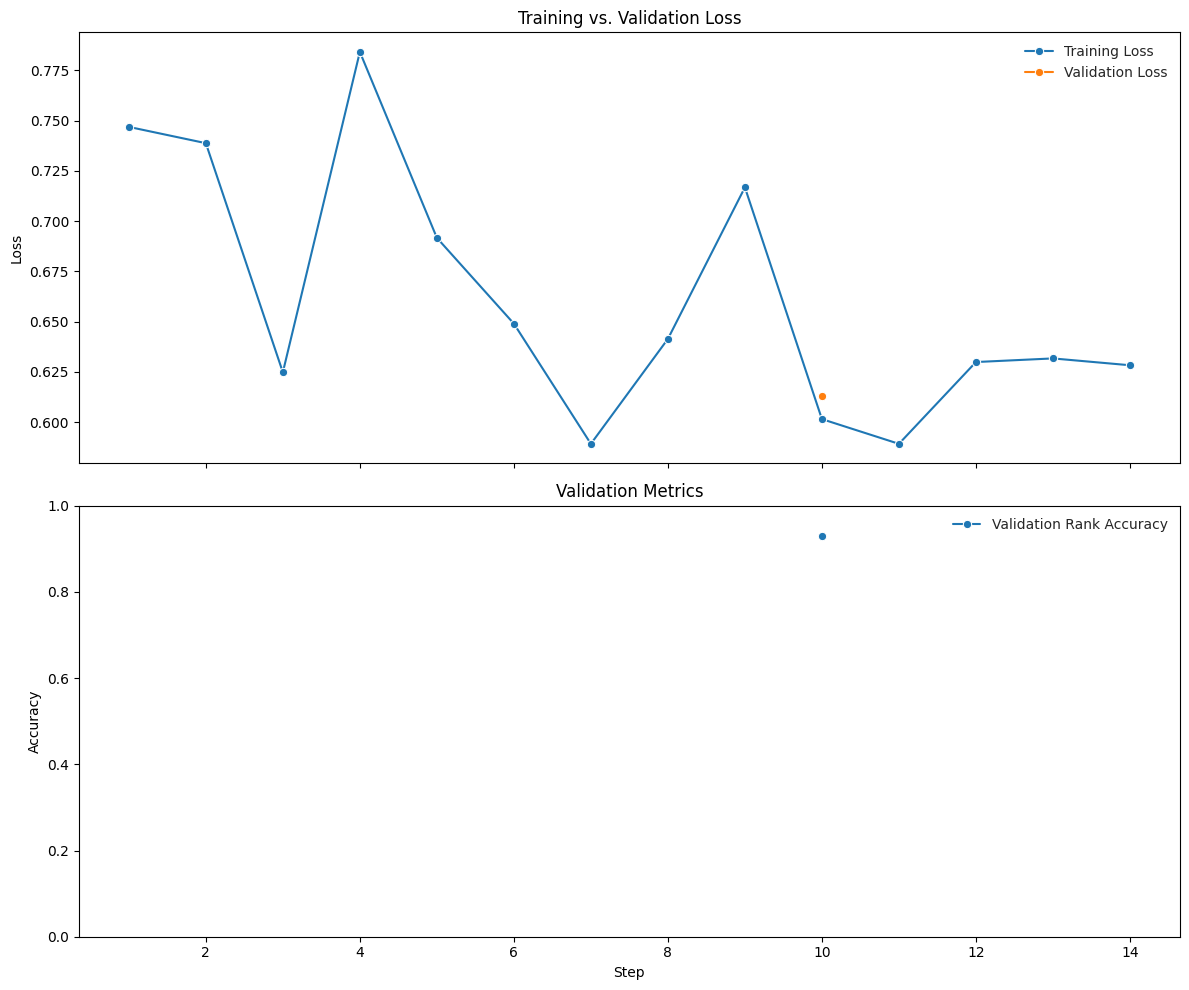


--- Best Model Evaluation Metrics (from validation set) ---
Best Step (based on min eval_loss): 10.0
Best Validation Loss: 0.6130
Best Validation Rank Accuracy: 0.9286


In [17]:
# --- 9. 訓練結果の可視化 ---
print("\n--- Visualizing Training Results ---")
log_history = trainer.state.log_history
df_log = pd.DataFrame(log_history)

df_train = df_log[df_log['loss'].notna()].copy()
df_eval = df_log[df_log['eval_loss'].notna()].copy()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
plt.style.use('seaborn-v0_8-whitegrid')

if not df_train.empty:
    sns.lineplot(data=df_train, x='step', y='loss', label='Training Loss', ax=ax1, marker='o')
if not df_eval.empty:
    sns.lineplot(data=df_eval, x='step', y='eval_loss', label='Validation Loss', ax=ax1, marker='o')
ax1.set_title('Training vs. Validation Loss')
ax1.set_ylabel('Loss')
ax1.legend()

if not df_eval.empty:
    # ▼▼▼ 修正点: 'eval_rank_accuracy' をプロット ▼▼▼
    sns.lineplot(data=df_eval, x='step', y='eval_rank_accuracy', label='Validation Rank Accuracy', ax=ax2, marker='o')
ax2.set_title('Validation Metrics')
ax2.set_ylabel('Accuracy')
ax2.set_xlabel('Step')
ax2.legend()
ax2.set_ylim(0, 1)

plt.tight_layout()
plt.show()

print("\n--- Best Model Evaluation Metrics (from validation set) ---")
if not df_eval.empty:
    best_run = df_eval.loc[df_eval['eval_loss'].idxmin()]
    print(f"Best Step (based on min eval_loss): {best_run['step']}")
    print(f"Best Validation Loss: {best_run['eval_loss']:.4f}")
    print(f"Best Validation Rank Accuracy: {best_run['eval_rank_accuracy']:.4f}")
else:
    print("No evaluation steps were completed.")